In [1]:
import numpy as np
from scipy.stats import norm


In [2]:

# --- Black-Scholes formula for a European put ---
def black_scholes_put(S, K, T, r, sigma):
    """
    S : spot price
    K : strike price
    T : time to maturity (in years)
    r : risk-free interest rate
    sigma : volatility
    Returns the price of a European put option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

# ---parameters ---
S0 = 10000         # initial portfolio value
T = 1               # 1 year
r = 0.022752        # risk-free rate
sigma = 0.1986      # historical volatility

# --- Strike Prices ---
strike_prices = [9000, 10000, 11000]
put_prices = {}

for K in strike_prices:
    price = black_scholes_put(S0, K, T, r, sigma)
    put_prices[K] = price
    print(f"Put price for K={K}: {price:.2f} €")

Put price for K=9000: 291.00 €
Put price for K=10000: 674.74 €
Put price for K=11000: 1251.01 €


In [3]:
import numpy as np
from scipy.stats import norm

# --- Black-Scholes formula for a European put ---
def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

# --- Parameters ---
initial_wealth = 10000
mu = 0.1266
sigma = 0.1986
T = 1
r = 0.022752
n_steps = 252
dt = T / n_steps
n_paths = 10000
strike_prices = [9000, 10000, 11000]
weights = [0.05, 0.10, 0.15, 0.20]

# --- Simulate index paths ---
np.random.seed(42)
Z = np.random.standard_normal((n_paths, n_steps))
paths = np.zeros_like(Z)
paths[:, 0] = initial_wealth

for t in range(1, n_steps):
    paths[:, t] = paths[:, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])

final_index_values = paths[:, -1]

# --- Loop over strikes and weights ---
results = {}

for K in strike_prices:
    put_price = black_scholes_put(initial_wealth, K, T, r, sigma)
    results[K] = {}
    for w in weights:
        budget_puts = initial_wealth * w
        n_puts = budget_puts / put_price
        remaining_equity = initial_wealth - budget_puts
        put_payoffs = np.maximum(K - final_index_values, 0)
        final_values = remaining_equity * (final_index_values / initial_wealth) + n_puts * put_payoffs

        # --- Discount to present value ---
        discounted_values = final_values * np.exp(-r * T)
        returns = discounted_values / initial_wealth - 1

        results[K][w] = {
            "final_values": final_values,
            "discounted_values": discounted_values,
            "returns": returns,
            "mean": np.mean(returns),
            "std": np.std(returns),
            "VaR_95": np.percentile(returns, 5),
            "ES_95": returns[returns <= np.percentile(returns, 5)].mean(),
            "VaR_99": np.percentile(returns, 1),
            "ES_99": returns[returns <= np.percentile(returns, 1)].mean(),
            "Sharpe": np.mean(returns) / np.std(returns),
        }

# --- Print results ---
for K, weight_results in results.items():
    print(f"\n===== Strike K = {K} =====")
    for w, res in weight_results.items():
        print(f"\n--- Put Weight = {int(w*100)}% ---")
        print(f"Mean return: {res['mean']:.4f}")
        print(f"Standard deviation: {res['std']:.4f}")
        print(f"VaR (95%): {res['VaR_95']:.4f}")
        print(f"ES (95%): {res['ES_95']:.4f}")
        print(f"VaR (99%): {res['VaR_99']:.4f}")
        print(f"ES (99%): {res['ES_99']:.4f}")
        print(f"Sharpe Ratio: {res['Sharpe']:.4f}")


===== Strike K = 9000 =====

--- Put Weight = 5% ---
Mean return: 0.0717
Standard deviation: 0.1833
VaR (95%): -0.1479
ES (95%): -0.1556
VaR (99%): -0.1600
ES (99%): -0.1621
Sharpe Ratio: 0.3910

--- Put Weight = 10% ---
Mean return: 0.0367
Standard deviation: 0.1723
VaR (95%): -0.1834
ES (95%): -0.1950
VaR (99%): -0.2025
ES (99%): -0.2052
Sharpe Ratio: 0.2128

--- Put Weight = 15% ---
Mean return: 0.0016
Standard deviation: 0.1901
VaR (95%): -0.2261
ES (95%): -0.2386
VaR (99%): -0.2464
ES (99%): -0.2491
Sharpe Ratio: 0.0085

--- Put Weight = 20% ---
Mean return: -0.0334
Standard deviation: 0.2303
VaR (95%): -0.2710
ES (95%): -0.2829
VaR (99%): -0.2906
ES (99%): -0.2931
Sharpe Ratio: -0.1451

===== Strike K = 10000 =====

--- Put Weight = 5% ---
Mean return: 0.0755
Standard deviation: 0.1785
VaR (95%): -0.1124
ES (95%): -0.1249
VaR (99%): -0.1328
ES (99%): -0.1415
Sharpe Ratio: 0.4233

--- Put Weight = 10% ---
Mean return: 0.0444
Standard deviation: 0.1503
VaR (95%): -0.1106
ES (95%):

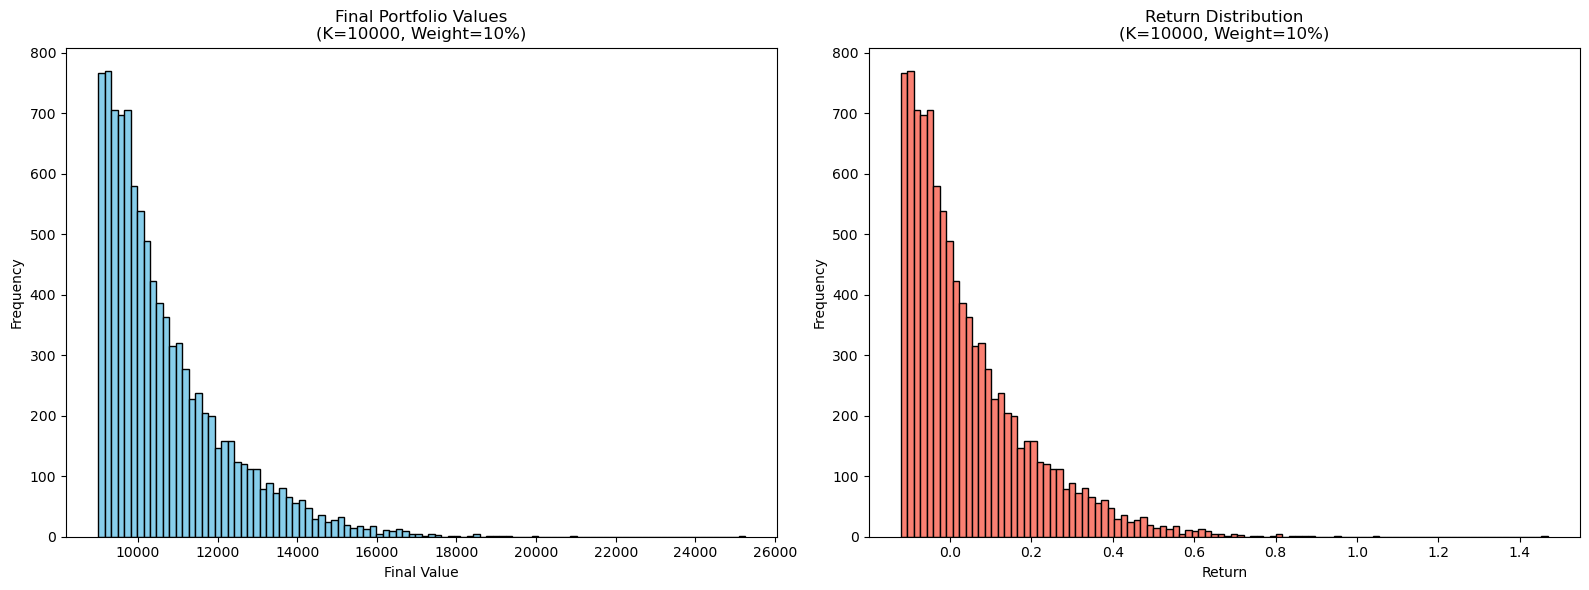

In [4]:
import matplotlib.pyplot as plt

# Choose the strike and weight 
selected_strike = 10000
selected_weight = 0.10

# Extract returns and final portfolio values
returns = results[selected_strike][selected_weight]['returns']
final_values = results[selected_strike][selected_weight]['final_values']

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Portfolio Value Distribution
axes[0].hist(final_values, bins=100, color='skyblue', edgecolor='black')
axes[0].set_title(f'Final Portfolio Values\n(K={selected_strike}, Weight={int(selected_weight*100)}%)')
axes[0].set_xlabel('Final Value')
axes[0].set_ylabel('Frequency')

# Return Distribution
axes[1].hist(returns, bins=100, color='salmon', edgecolor='black')
axes[1].set_title(f'Return Distribution\n(K={selected_strike}, Weight={int(selected_weight*100)}%)')
axes[1].set_xlabel('Return')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

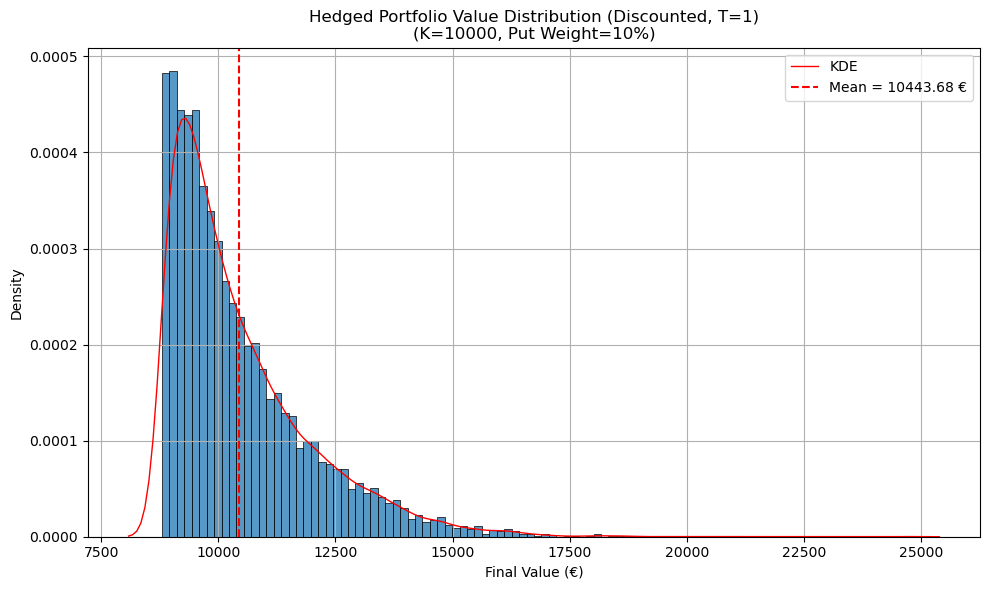

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extract hedged portfolio discounted values
selected_strike = 10000
selected_weight = 0.1
discounted_values_hedged = results[selected_strike][selected_weight]['discounted_values']

# Plot distribution of discounted portfolio values (hedged)
plt.figure(figsize=(10, 6))
sns.histplot(discounted_values_hedged, bins=100, stat='density', edgecolor='black', color='#1f77b4')
sns.kdeplot(discounted_values_hedged, color='red', linewidth=1, label='KDE')
plt.axvline(np.mean(discounted_values_hedged), color='red', linestyle='--', label=f"Mean = {np.mean(discounted_values_hedged):.2f} €")

plt.title("Hedged Portfolio Value Distribution (Discounted, T=1)\n(K=10000, Put Weight=10%)")
plt.xlabel("Final Value (€)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

# --- Final Layout ---
plt.tight_layout()
#plt.savefig("hedged_K10000_W10.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()